In [2]:
SEARCH_TERM = "America"
TWEETS_COUNT = 300
TIME_LIMIT = 120



import keys
import os
import pandas as pd
import numpy as np
import tweepy
from tweepy import OAuthHandler
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

dir_path = os.getcwd()
dir_path_data = dir_path + "/Data/"


consumer_key = keys.consumer_key
consumer_secret = keys.consumer_secret
access_token = keys.access_token
access_secret = keys.access_secret


print(consumer_key)
print(consumer_secret)
print(access_token)
print(access_secret)


print(dir_path)
print(dir_path_data)

 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)


HImrEBDPQ1v30Ms8yevMAtOc2
hwmtGELZmLXHAaV1Xok9lkUjNjB3n3fu8SMvnGJv1ofnfMKqd0
354844313-ITXlT4314nPV3WxXjEcgq5xlVecRgK2KItdTjkJV
rBvKgdyZaOgcMj5xULpTYZfWaLjlm4wH3qbcUSwJf65tq
/home/karthikeya/ProjectsSJSU/ML_Project
/home/karthikeya/ProjectsSJSU/ML_Project/Data/


In [3]:
# Before running this code
# make a directory named Data and provide the path of the directory at INPUT_DATAPATH
# set SEARCH_TERM as what you would like to search from twitter "ex: apple"
# which would produce the list of tweets for the term "apple" 
# and also store the twitter data into the file stream_apple.json in the directory of INPUT_DATAPATH


from tweepy import Stream
from tweepy.streaming import StreamListener
import time
import string
import json
import time
import os


class MyListener(StreamListener):
    """Custom StreamListener for streaming data."""

    def __init__(self, data_dir, query, time_limit):
        query_fname = ''.join(convert_valid(one_char) for one_char in query)
        self.start_time = time.time()
        self.limit = TIME_LIMIT
        self.outfile = "%s/stream_%s.json" % (data_dir, query_fname)
        
    def on_data(self, data):
        # removes if a file already exists with same name and creates new file and writes into that
        
        if os.path.exists(self.outfile):
            if os.path.getsize(self.outfile) > 2**20 * 2**10: # 1MB
                os.remove(self.outfile)
        with open(self.outfile,'a') as f:
            try:
                f.writelines(data.strip("\n"))

                if (time.time() - self.start_time) > self.limit:
                    print('WRITE COMPLETE')
                    time.sleep(1)
                    f.close()
                    return False
                return True

            except BaseException as e:
                print("Error on_data: %s" % str(e))
                time.sleep(5)


    def on_error(self, status):
        print(status)
        return True

    
def convert_valid(one_char):
    """Convert a character into '_' if invalid.
    Arguments:
        one_char -- the char to convert
    Return:
        Character -- converted char
    """
    valid_chars = "-_.%s%s" % (string.ascii_letters, string.digits)
    if one_char in valid_chars:
        return one_char
    else:
        return '_'
 


In [4]:
twitter_stream = Stream(auth, MyListener(dir_path_data, SEARCH_TERM, TIME_LIMIT)) #calling stream function to stream in live data
twitter_stream.filter(track=[SEARCH_TERM]) # filters data based on search term on storing

WRITE COMPLETE


In [6]:
from nltk.tokenize import word_tokenize, TweetTokenizer
import re
import operator 
import json
from collections import Counter
from nltk.corpus import stopwords
import string
from nltk import bigrams 
from collections import defaultdict
import nltk

com = defaultdict(lambda : defaultdict(int))
    
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via', 'RT', ':', ',', '‚Äô',
                                                   'i\'m', '‚Ä¶', '...', 'a', 'b', 'c'
                                                  'd','g','j','m','p','s','v','y',
                                                  'e','h','k','n','q','t','w','z',
                                                  'f','i','l','o','r','u','x', 'http', 'https',
                                                  '√≥','‡§≤','‡•Å','‡Øç','‡§ú','I','‡§¨','‡§Ø','‡§¶','‡•à','‡§ü',
                                                   '‡§≠','‡§ó','‡§™','‡§µ','‡Æø','‡§∂','amp',
                                                   '‡•Ç','‡•§','‡§ß','‡ØÅ','‡§ö','1','‡§æ',]    

      
terms=''
tknzr = TweetTokenizer()
num_of_tweets = 0
tweets = []
original_tweets = []
fname = dir_path_data +'/stream_'+SEARCH_TERM+'.json'
with open(fname, 'r') as f:
    count_all = Counter()
    
    for line in f:
        num_of_tweets += 1
        tweet = json.loads(line)
        # Create a list with all the terms
        original = ''
        if 'extended_tweet' in tweet:
            terms = [term.replace('#', '') for term in tknzr.tokenize(tweet['extended_tweet']['full_text']) if term.lower() not in stop 
                                                                    and 'http' not in term
                                                                    and not term.startswith('@')]
            original = tweet.get('extended_tweet').get('full_text')
            
        elif 'retweeted_status' in tweet:
            try:
                terms = [term.replace('#', '') for term in tknzr.tokenize(tweet['retweeted_status']['extended_tweet']['full_text']) if term.lower() not in stop 
                                                                    and 'http' not in term
                                                                    and not term.startswith('@')]
                original = tweet.get('retweeted_status').get('extended_tweet').get('full_text')
            except:
                pass
        else:
            try:
                terms = [term.replace('#', '') for term in tknzr.tokenize(tweet['text']) if term.lower() not in stop 
                                                                    and 'http' not in term
                                                                    and not term.startswith('@')]
                original = tweet['text']
            except:
                pass
        
#         print(original)
        tweets.append(terms)
        original_tweets.append(original)
        terms_bigram = list(nltk.bigrams(terms))
        
#         print(terms)
#         print(terms_bigram)

        # Build co-occurrence matrix
        for i in range(len(terms)-1):            
            for j in range(i+1, len(terms)):
                w1, w2 = sorted([terms[i], terms[j]])                
                if w1 != w2:
                    com[w1][w2] += 1
    
        # Update the counter
        count_all.update(terms_bigram)
        
# Print the first 5 most frequent words
# print(count_all.most_common(10))


original_tweets = list(filter(None, original_tweets))
# every single tweet vocab put into a list
flat_list = [term for tweet in tweets for term in tweet ]
hashtags_list = [hasht for hasht in flat_list if hasht.startswith('#')]

all_terms_dist = nltk.FreqDist(flat_list)
hash_terms_dist = nltk.FreqDist(hashtags_list)


print(all_terms_dist.most_common(10))

# print(count_all.most_common())


com_max = []
# For each term, look for the most common co-occurrent terms
for t1 in com:
    t1_max_terms = sorted(com[t1].items(), key=operator.itemgetter(1), reverse=True)[:5]
    for t2, t2_count in t1_max_terms:
        com_max.append(((t1, t2), t2_count))
# Get the most frequent co-occurrences
terms_max = sorted(com_max, key=operator.itemgetter(1), reverse=True)
print(terms_max[:10])

print(num_of_tweets)


'''
Bigrams
A collocation is a sequence of words that occur together unusually often. 
Thus red wine is a collocation, whereas the wine is not. 
A characteristic of collocations is that they are resistant to substitution
with words that have similar senses; for example, maroon wine sounds definitely odd.
'''

''''''

[('America', 1036), ('18', 633), ('2018.5', 588), ('‚Äò', 394), ('LOVE', 391), ('Tear', 391), ('ËΩâ', 389), ('AMERICA', 249), ('PDT', 198), ('EDT', 198)]
[(('18', '2018.5'), 1764), (('18', 'Tear'), 1171), (('18', 'LOVE'), 1167), (('18', 'ËΩâ'), 1167), (('18', '‚Äò'), 1167), (('2018.5', 'LOVE'), 1167), (('2018.5', 'ËΩâ'), 1167), (('2018.5', '‚Äò'), 1167), (('2018.5', 'Tear'), 1167), (('LOVE', 'ËΩâ'), 775)]
1487


''

In [7]:
import math
from nltk.corpus import opinion_lexicon


# n_docs is the total n. of tweets
p_t = {}
p_t_com = defaultdict(lambda : defaultdict(int))
 
for term, n in all_terms_dist.most_common():
    p_t[term] = n / num_of_tweets
    for t2 in com[term]:
        p_t_com[term][t2] = com[term][t2] / num_of_tweets
        

positive_lex = opinion_lexicon.positive()[:]   
negative_lex = opinion_lexicon.negative()[:]
positive_vocab = [
    'good', 'nice', 'great', 'awesome', 'outstanding',
    'fantastic', 'terrific', ':)', ':-)', 'like', 'love',
    # shall we also include game-specific terms?
    # 'triumph', 'triumphal', 'triumphant', 'victory', etc.
]
positive_vocab += positive_lex
negative_vocab = [
    'bad', 'terrible', 'crap', 'useless', 'hate', ':(', ':-(',
    # 'defeat', etc.
]
negative_vocab += negative_lex

pmi = defaultdict(lambda : defaultdict(int))
for t1 in p_t:
    for t2 in com[t1]:
        denom = p_t[t1] * p_t[t2]
        pmi[t1][t2] = math.log2(p_t_com[t1][t2] / denom)
 
semantic_orientation = {}
for term, n in p_t.items():
    positive_assoc = sum(pmi[term][tx] for tx in positive_vocab)
    negative_assoc = sum(pmi[term][tx] for tx in negative_vocab)
    semantic_orientation[term] = positive_assoc - negative_assoc

semantic_sorted = sorted(semantic_orientation.items(), 
                         key=operator.itemgetter(1), 
                         reverse=True)
top_pos = semantic_sorted[:10]
top_neg = semantic_sorted[-10:]
 
print(top_pos)
print(top_neg)

# print(semantic_sorted)



[('dear', 46.6033676817458), ('Grateful', 46.6033676817458), ('GetWellSoon', 46.6033676817458), ('look', 42.694319495936966), ('friend', 41.89134557722635), ('day', 41.006841908261116), ('Top', 39.955509561413585), ('Docs', 39.955509561413585), ('behalf', 38.461856608028974), ('Hopefully', 37.56779322748852)]
[('dead', -64.1867204592026), ('care', -64.57042107876188), ('4', -70.52060030326605), ('country', -77.82781640844439), ('Russians', -79.33943691753002), ('funny', -80.70532139882985), ('America', -81.27816311682368), ('blind', -84.94878686529013), ('American', -86.61410723951388), ('Trump', -88.36346001500641)]


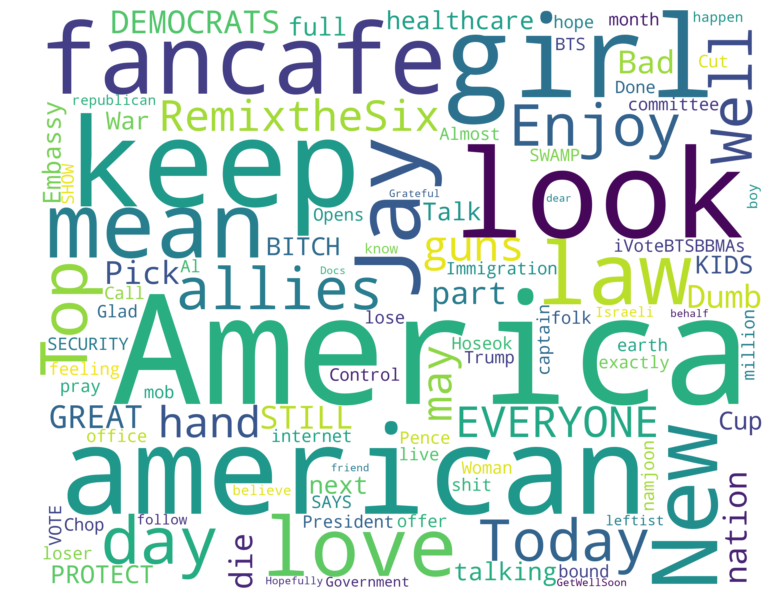

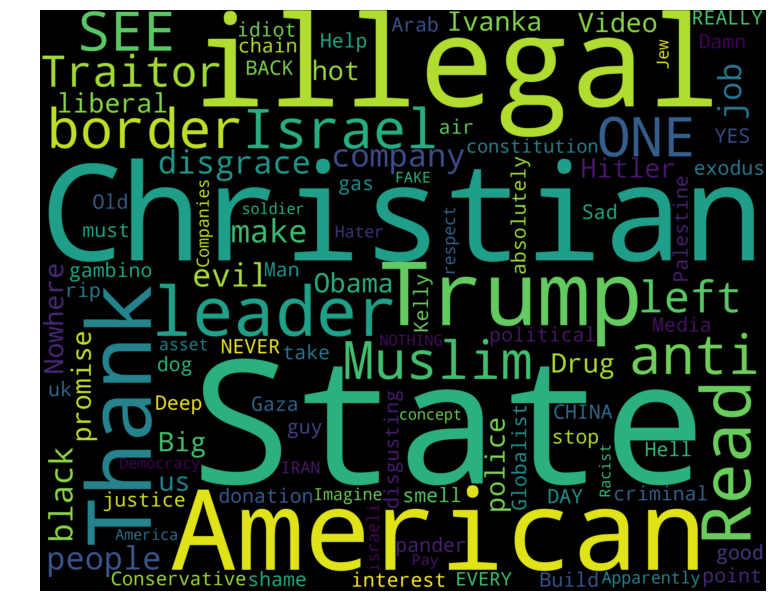

In [8]:
from wordcloud import WordCloud
import random

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    wordcloud = WordCloud(background_color=color,
                      width=2500,
                      height=2000,
                      max_words=100
                     ).generate(words)
#     wordcloud.recolor(color_func = grey_color_func(word = words))
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

pos_term = [terms[0] for terms in semantic_sorted if terms[1] > 0 
            and not terms[0].startswith('@')]

neg_term = [terms[0] for terms in semantic_sorted if terms[1] < 0 
            and not terms[0].startswith('@')]

neutral_term = [terms[0] for terms in semantic_sorted if terms[1] == 0 
            and not terms[0].startswith('@')]

wordcloud_draw(pos_term, 'white')
wordcloud_draw(neg_term)




In [9]:
count = 0
target = []
for tweet in original_tweets:
    score = 0
    pos_counter = 0
    neg_counter = 0
    for word in semantic_sorted:
        if word[0].lower() in tweet.lower() and not word[0].isdigit() and len(word[0]) >= 3:
#             print(word)
            if word[1] > 0:
                pos_counter += 1
            if word[1] < 0:
                neg_counter += 1
        
            score += word[1]
    if(pos_counter > neg_counter or score > 0):
        count += 1
        sentiment = 'Positive'
    else:
        sentiment = 'Negative'
    target.append(sentiment)

In [10]:
print(count)
print(len(original_tweets))
print(len(target))

319
1059
1059


In [11]:
# We create a pandas dataframe as follows:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df = pd.DataFrame(data=[tweet for tweet in original_tweets], columns=['text'])
df['sentiment']  = np.array([sentiment for sentiment in target])

In [12]:
import re
from textblob import TextBlob


def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analyze_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
#     print(clean_tweet(tweet))
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 'Positive'
#     elif ( analysis.sentiment.polarity == 0):
#         return 'Neutral'
    else:
        return 'Negative'

def analyze_subject(tweet):
    '''
    Utility function to classify the subjectivity of a tweet
    using textblob.
    '''
#     print(clean_tweet(tweet))
    analysis = TextBlob(clean_tweet(tweet))
    return analysis.sentiment.subjectivity
#     if analysis.sentiment.subjectivity > 0.5:
#         return 'Subjective'
#     else:
#         return 'Not Subjective'



# We create a column with the result of the analysis:
df['SA'] = np.array([ analyze_sentiment(tweet) for tweet in df['text'] ])
df['Subjective'] = np.array([ analyze_subject(tweet) for tweet in df['text'] ])

# We display the updated dataframe with the new column:
display(df[['text', 'SA', 'Subjective']].head())

pos_tweets_SA = [ tweet for index, tweet in enumerate(df['text']) if df['SA'][index] == 'Positive']
neg_tweets_SA = [ tweet for index, tweet in enumerate(df['text']) if df['SA'][index] == 'Negative']
# neu_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['SA'][index] == 'Neutral']

pos_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['sentiment'][index] == 'Positive']
neg_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['sentiment'][index] == 'Negative']

print("Percentage of positive tweets SA: {}%".format(len(pos_tweets_SA)*100/len(df['text'])))
print("Percentage de negative tweets SA: {}%".format(len(neg_tweets_SA)*100/len(df['text'])))

print("Percentage of positive tweets Sentiment: {}%".format(len(pos_tweets)*100/len(df['text'])))
print("Percentage de negative tweets Sentiment: {}%".format(len(neg_tweets)*100/len(df['text'])))
# print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(df['text'])))

text  \
0  What  a  shame to  America ? https://t.co/hnVvRhEAs3                                                                                                                                                                                         
1  If every black man over 18 with no criminal record in America applied for a conceal/carry license and joined the NRA, I promise you there would be gun reform laws enacted the very next week.                                               
2  God Bless America! https://t.co/aV8soVBfnc                                                                                                                                                                                                   
3  [Í≥µÏßÄ] LOVE YOURSELF ËΩâ¬†‚ÄòTear‚Äô Ìã∞Ï†Ä ÏòÅÏÉÅ ÎÇ¥ Î∞úÎß§Ïùº Ï†ïÎ≥¥ ÏàòÏ†ï \n\nÌïúÍµ≠ : 2018.5.18 6PM KST\n\nÌòºÏÑ†ÏùÑ ÎìúÎ†§ÏÑú Ï£ÑÏÜ°Ìï©ÎãàÎã§.\n\n[Notice] Release Date Edited in LOVE YOURSELF¬†ËΩâ¬†‚ÄòTear‚Äô¬†Teaser\n\nAMERICA : 2018.5.18 2AM PDT / 2018.5.18 5AM EDT\n\nSorry for the confusion.   
4  [Í≥µÏßÄ] LOVE YOURSELF ËΩâ¬†‚ÄòTear‚Äô Ìã∞Ï†Ä ÏòÅÏÉÅ ÎÇ¥ Î∞úÎß§Ïùº Ï†ïÎ≥¥ ÏàòÏ†ï \n\nÌïúÍµ≠ : 2018.5.18 6PM KST\n\nÌòºÏÑ†ÏùÑ ÎìúÎ†§ÏÑú Ï£ÑÏÜ°Ìï©ÎãàÎã§.\n\n[Notice] Release Date Edited in LOVE YOURSELF¬†ËΩâ¬†‚ÄòTear‚Äô¬†Teaser\n\nAMERICA : 2018.5.18 2AM PDT / 2018.5.18 5AM EDT\n\nSorry for the confusion.   

         SA  Subjective  
0  Negative  0.000000    
1  Positive  0.327778    
2  Negative  0.000000    
3  Positive  0.733333    
4  Positive  0.733333

Percentage of positive tweets SA: 58.07365439093484%
Percentage de negative tweets SA: 41.92634560906516%
Percentage of positive tweets Sentiment: 30.12275731822474%
Percentage de negative tweets Sentiment: 69.87724268177526%


In [13]:
df.head(50)

text  \
0   What  a  shame to  America ? https://t.co/hnVvRhEAs3                                                                                                                                                                                                                                                                
1   If every black man over 18 with no criminal record in America applied for a conceal/carry license and joined the NRA, I promise you there would be gun reform laws enacted the very next week.                                                                                                                      
2   God Bless America! https://t.co/aV8soVBfnc                                                                                                                                                                                                                                                                          
3   [Í≥µÏßÄ] LOVE YOURSELF ËΩâ¬†‚ÄòTear‚Äô Ìã∞Ï†Ä ÏòÅÏÉÅ ÎÇ¥ Î∞úÎß§Ïùº Ï†ïÎ≥¥ ÏàòÏ†ï \n\nÌïúÍµ≠ : 2018.5.18 6PM KST\n\nÌòºÏÑ†ÏùÑ ÎìúÎ†§ÏÑú Ï£ÑÏÜ°Ìï©ÎãàÎã§.\n\n[Notice] Release Date Edited in LOVE YOURSELF¬†ËΩâ¬†‚ÄòTear‚Äô¬†Teaser\n\nAMERICA : 2018.5.18 2AM PDT / 2018.5.18 5AM EDT\n\nSorry for the confusion.                                                                          
4   [Í≥µÏßÄ] LOVE YOURSELF ËΩâ¬†‚ÄòTear‚Äô Ìã∞Ï†Ä ÏòÅÏÉÅ ÎÇ¥ Î∞úÎß§Ïùº Ï†ïÎ≥¥ ÏàòÏ†ï \n\nÌïúÍµ≠ : 2018.5.18 6PM KST\n\nÌòºÏÑ†ÏùÑ ÎìúÎ†§ÏÑú Ï£ÑÏÜ°Ìï©ÎãàÎã§.\n\n[Notice] Release Date Edited in LOVE YOURSELF¬†ËΩâ¬†‚ÄòTear‚Äô¬†Teaser\n\nAMERICA : 2018.5.18 2AM PDT / 2018.5.18 5AM EDT\n\nSorry for the confusion.                                                                          
5   We over-incarcerate in America‚Äîexploding the prison population, and undermining faith in our criminal justice system. We can protect communities while ensuring mandatory minimums don't unfairly punish people. I'm proud to cosponsor the Sentencing Reform and Corrections Act.                                  
6   Not even America‚Äôs best hospital can handle 2000 patients critically injured by live ammo. A triage situation would be in place and patients diverted. Gaza‚Äôs hospitals are severely understaffed and undersupplied. Nowhere to divert. It‚Äôs a humanitarian and healthcare catastrophe.                             
7   We must be clear: these men do not preach Jesus, but #SlaveholderReligion. America needs a moral revolution of values. #PoorPeoplesCampaign https://t.co/46deZsdAFu                                                                                                                                                 
8   *bts interview in America*\n\nInterviewer: So how are you guys finding the American atmosphere?\n\nYoongi: *in korean* I swear to god if I hear Hoseok calling himself Jay-Dope one more time I‚Äôm about to cut a btch, I didn‚Äôt sign up for this\n\nNamjoon: He says it‚Äôs great :)                                  
9   ‚ÄúIf we can begin to see strangers as sisters and brothers then we are more likely to step into the fire when they need us.‚Äù - @valariekaur on United Shades Of America with @wkamaubell #UnitedShades                                                                                                               
10  @Eugene_Robinson The Schlapps are THE SWAMP! Making money off of every American and eroding what is good and true about America, we will have a lot to clean up after this horrid administration!                                                                                                                   
11  [Í≥µÏßÄ] LOVE YOURSELF ËΩâ¬†‚ÄòTear‚Äô Ìã∞Ï†Ä ÏòÅÏÉÅ ÎÇ¥ Î∞úÎß§Ïùº Ï†ïÎ≥¥ ÏàòÏ†ï \n\nÌïúÍµ≠ : 2018.5.18 6PM KST\n\nÌòºÏÑ†ÏùÑ ÎìúÎ†§ÏÑú Ï£ÑÏÜ°Ìï©ÎãàÎã§.\n\n[Notice] Release Date Edited in LOVE YOURSELF¬†ËΩâ¬†‚ÄòTear‚Äô¬†Teaser\n\nAMERICA : 2018.5.18 2AM PDT / 2018.5.18 5AM EDT\n\nSorry for the confusion.                                                                          
12  N√£o

In [14]:
import re, nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    only_letters = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet)
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens if len(l) >= 3]
    filtered_result = list(filter(lambda l: l not in stop, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [15]:
df['normalized_tweet'] = df.text.apply(normalizer)
df[['text','normalized_tweet']].head(10)

text  \
0  What  a  shame to  America ? https://t.co/hnVvRhEAs3                                                                                                                                                                                                                                      
1  If every black man over 18 with no criminal record in America applied for a conceal/carry license and joined the NRA, I promise you there would be gun reform laws enacted the very next week.                                                                                            
2  God Bless America! https://t.co/aV8soVBfnc                                                                                                                                                                                                                                                
3  [Í≥µÏßÄ] LOVE YOURSELF ËΩâ¬†‚ÄòTear‚Äô Ìã∞Ï†Ä ÏòÅÏÉÅ ÎÇ¥ Î∞úÎß§Ïùº Ï†ïÎ≥¥ ÏàòÏ†ï \n\nÌïúÍµ≠ : 2018.5.18 6PM KST\n\nÌòºÏÑ†ÏùÑ ÎìúÎ†§ÏÑú Ï£ÑÏÜ°Ìï©ÎãàÎã§.\n\n[Notice] Release Date Edited in LOVE YOURSELF¬†ËΩâ¬†‚ÄòTear‚Äô¬†Teaser\n\nAMERICA : 2018.5.18 2AM PDT / 2018.5.18 5AM EDT\n\nSorry for the confusion.                                                
4  [Í≥µÏßÄ] LOVE YOURSELF ËΩâ¬†‚ÄòTear‚Äô Ìã∞Ï†Ä ÏòÅÏÉÅ ÎÇ¥ Î∞úÎß§Ïùº Ï†ïÎ≥¥ ÏàòÏ†ï \n\nÌïúÍµ≠ : 2018.5.18 6PM KST\n\nÌòºÏÑ†ÏùÑ ÎìúÎ†§ÏÑú Ï£ÑÏÜ°Ìï©ÎãàÎã§.\n\n[Notice] Release Date Edited in LOVE YOURSELF¬†ËΩâ¬†‚ÄòTear‚Äô¬†Teaser\n\nAMERICA : 2018.5.18 2AM PDT / 2018.5.18 5AM EDT\n\nSorry for the confusion.                                                
5  We over-incarcerate in America‚Äîexploding the prison population, and undermining faith in our criminal justice system. We can protect communities while ensuring mandatory minimums don't unfairly punish people. I'm proud to cosponsor the Sentencing Reform and Corrections Act.        
6  Not even America‚Äôs best hospital can handle 2000 patients critically injured by live ammo. A triage situation would be in place and patients diverted. Gaza‚Äôs hospitals are severely understaffed and undersupplied. Nowhere to divert. It‚Äôs a humanitarian and healthcare catastrophe.   
7  We must be clear: these men do not preach Jesus, but #SlaveholderReligion. America needs a moral revolution of values. #PoorPeoplesCampaign https://t.co/46deZsdAFu                                                                                                                       
8  *bts interview in America*\n\nInterviewer: So how are you guys finding the American atmosphere?\n\nYoongi: *in korean* I swear to god if I hear Hoseok calling himself Jay-Dope one more time I‚Äôm about to cut a btch, I didn‚Äôt sign up for this\n\nNamjoon: He says it‚Äôs great :)        
9  ‚ÄúIf we can begin to see strangers as sisters and brothers then we are more likely to step into the fire when they need us.‚Äù - @valariekaur on United Shades Of America with @wkamaubell #UnitedShades                                                                                     

                                                                                                                                                                                                                                       normalized_tweet  
0  [shame, america]                                                                                                                                                                                                                                      
1  [black, man, criminal, record, america, applied, conceal, carry, license, joined, nra, promise, would, gun, reform, law, enacted, next, week]                                                                                                         
2  [america]                                                                                                                                                                                                                   

In [16]:
import pickle

def load_pickle(file_name):
    with open(file_name + '.pickle', 'rb') as file:
        classifier = pickle.load(file)
    return classifier

In [17]:
classifier = load_pickle('vec_clf')

In [18]:
# classifier.score(data_test, targets_test)
# predicted = classifier.predict(vectorized_data)
print(classifier)
def sentiment2target(sentiment):
    return {
        'Negative': 0,
        'Positive' : 1
    }[sentiment]

# Convert Classification into integer for speed and space efficiency reasons
targets_SA = df.SA.apply(sentiment2target)
targets_sentiment = df.sentiment.apply(sentiment2target)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
       ...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


In [20]:
predicted = classifier.predict(df.text)
np.mean(predicted == targets_SA)

0.6506137865911237

In [21]:
np.mean(predicted == targets_sentiment)

0.45797922568460814

In [22]:
count_pre = 0
count_pos = 0
for pre in predicted:
    if pre == 1:
        count_pos += 1
        print(df.text[count_pre])
        print("")
    count_pre += 1

If every black man over 18 with no criminal record in America applied for a conceal/carry license and joined the NRA, I promise you there would be gun reform laws enacted the very next week.

God Bless America! https://t.co/aV8soVBfnc

[Í≥µÏßÄ] LOVE YOURSELF ËΩâ¬†‚ÄòTear‚Äô Ìã∞Ï†Ä ÏòÅÏÉÅ ÎÇ¥ Î∞úÎß§Ïùº Ï†ïÎ≥¥ ÏàòÏ†ï 

ÌïúÍµ≠ : 2018.5.18 6PM KST

ÌòºÏÑ†ÏùÑ ÎìúÎ†§ÏÑú Ï£ÑÏÜ°Ìï©ÎãàÎã§.

[Notice] Release Date Edited in LOVE YOURSELF¬†ËΩâ¬†‚ÄòTear‚Äô¬†Teaser

AMERICA : 2018.5.18 2AM PDT / 2018.5.18 5AM EDT

Sorry for the confusion.

[Í≥µÏßÄ] LOVE YOURSELF ËΩâ¬†‚ÄòTear‚Äô Ìã∞Ï†Ä ÏòÅÏÉÅ ÎÇ¥ Î∞úÎß§Ïùº Ï†ïÎ≥¥ ÏàòÏ†ï 

ÌïúÍµ≠ : 2018.5.18 6PM KST

ÌòºÏÑ†ÏùÑ ÎìúÎ†§ÏÑú Ï£ÑÏÜ°Ìï©ÎãàÎã§.

[Notice] Release Date Edited in LOVE YOURSELF¬†ËΩâ¬†‚ÄòTear‚Äô¬†Teaser

AMERICA : 2018.5.18 2AM PDT / 2018.5.18 5AM EDT

Sorry for the confusion.

We over-incarcerate in America‚Äîexploding the prison population, and undermining faith in our criminal justice system. We can protect communities while ensuring mandatory 

Sorry for the confusion.

America is now a ‚Äúflawed‚Äù democracy.   Thanks a lot @realDonaldTrump. What an absolute dickhead. You are a menace to all things good &amp; righteous in this world.  üñï

#TrumpCrimeFamily
#GOPTraitors
#BlueTsunami
#BlueWave
#TheResistance
#FBR
ü§òüá∫üá∏üçä

https://t.co/N0C6tLmPwN

Me gust√≥ un video de @YouTube https://t.co/YpNt0sEWTd Childish Gambino - This Is America (Official Video)

[Í≥µÏßÄ] LOVE YOURSELF ËΩâ¬†‚ÄòTear‚Äô Ìã∞Ï†Ä ÏòÅÏÉÅ ÎÇ¥ Î∞úÎß§Ïùº Ï†ïÎ≥¥ ÏàòÏ†ï 

ÌïúÍµ≠ : 2018.5.18 6PM KST

ÌòºÏÑ†ÏùÑ ÎìúÎ†§ÏÑú Ï£ÑÏÜ°Ìï©ÎãàÎã§.

[Notice] Release Date Edited in LOVE YOURSELF¬†ËΩâ¬†‚ÄòTear‚Äô¬†Teaser

AMERICA : 2018.5.18 2AM PDT / 2018.5.18 5AM EDT

Sorry for the confusion.

@NBCTheVoice @itsjackiefoster Omg tht was unbelievable I'm in shock America plz plz vote Jackie to the finale she rly rly deserves it ppl she did such an amazing job

Thanks to Trump:

-Iran has announced it will restart its nuclear program.

-The # of Arab youth worldwide who 

In [23]:
print(count_pre)
print(count_pos)
print("Percentage of Positive tweets: ", str((count_pos/count_pre)*100), "%")
print("Percentage of Negative tweets: ", str(((count_pre-count_pos)/count_pre)*100), "%")

1059
609
Percentage of Positive tweets:  57.50708215297451 %
Percentage of Negative tweets:  42.492917847025495 %


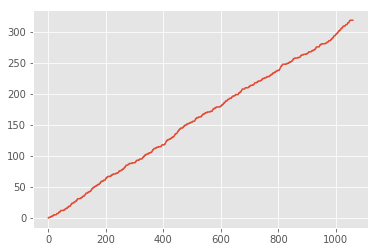

In [28]:
import matplotlib.animation as animation
from matplotlib import rc
from matplotlib import style
from IPython.display import HTML, Image


# rc('animation', html='html5')
# fig, ax = plt.subplots()
# plt.rcParams["animation.html"] = "jshtml"
# li, = ax.plot([], [], lw=2)

style.use("ggplot")

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

def animate(i):
    #pulldata = targets_sentiment
    
    xar = []
    yar = []
    
    x = 0
    y = 0
    
    for sentiment in targets_sentiment:
        x+=1
        if sentiment!=' ':            
            a = float(sentiment)
            y+=a
            xar.append(x)
            yar.append(y)
 
#     li.set_data(x,y)
#     return (li,)
#ani = animation.FuncAnimation(fig, animate, interval=100,frames=10)
#ani.save('/images/animation.html', fps=60)
#Image(url='/images/animation.html')

        
    ax1.clear()
    ax1.plot(xar,yar)
ani = animation.FuncAnimation(fig, animate, interval=100)
plt.show()
